## **Arsitektur Hybrid CNN: VGG16 + EfficientNetB0 dengan CBAM**
**Berdasarkan Paper**

Rani R, Bharany S, Elkamchouchi DH, Ur Rehman A, Singh R, Hussen S. VGG-EffAttnNet: Hybrid Deep Learning Model for Automated Chili Plant Disease Classification Using VGG16 and EfficientNetB0 With Attention Mechanism. Food Sci Nutr. 2025 Jul 24;13(7):e70653. doi: 10.1002/fsn3.70653. PMID: 40708782; PMCID: PMC12288623.

**Dataset** : Chili Plant Leaf Disease and Growth Stage Dataset from Bangladesh
 https://data.mendeley.com/datasets/w9mr3vf56s/1
### **Diagram Arsitektur**

```
INPUT (224, 224, 3)
     ↓
  ┌─────────────────────────────────────────────────┐
  │              PREPROCESSING LAYERS               │
  │ • Rescaling (0-255 → 0-1)                       │
  │ • Normalization (Custom)                        │
  │ • Rescaling_1 (Additional)                      │
  └─────────────────────────────────────────────────┘
     ↓
  ┌─────────────────┐    ┌─────────────────────────────┐
  │   BRANCH 1      │    │       BRANCH 2              │
  │   VGG16 PATH    │    │   EfficientNetB0 + CBAM     │
  │                 │    │                             │
  │ Conv2D (64)     │    │ Stem Layers                 │
  │ Conv2D (64)     │    │ (Conv2D + BN + Activation)  │
  │ MaxPooling2D    │    │     ↓                       │
  │ Conv2D (128)    │    │ MBConv Blocks 1-7           │
  │ Conv2D (128)    │    │ with SE Attention           │
  │ MaxPooling2D    │    │     ↓                       │
  │ Conv2D (256)    │    │ Top Conv (1280 channels)    │
  │ Conv2D (256)    │    │     ↓                       │
  │ Conv2D (256)    │    │ CBAM Block:                 │
  │ MaxPooling2D    │    │   - GlobalAvgPool +         │
  │ Conv2D (512)    │    │     GlobalMaxPool           │
  │ Conv2D (512)    │    │   - Dense(80) + Dense(1280) │
  │ Conv2D (512)    │    │   - Add + Activation        │
  │ MaxPooling2D    │    │   - Multiply (Channel Att.) │
  │ Conv2D (512)    │    │   - Lambda (Spatial Avg/Max)│
  │ Conv2D (512)    │    │   - Concatenate + Conv2D    │
  │ Conv2D (512)    │    │   - Multiply (Spatial Att.) │
  │ MaxPooling2D    │    │     ↓                       │
  │ Flatten()       │    │ GlobalAveragePooling2D      │
  │     ↓           │    │     ↓                       │
  │ Dense(256)      │    │ Dense(256)                  │
  │     ↓           │    │     ↓                       │
  │ Dropout(0.5)    │    │ Dropout(0.5)                │
  └─────────────────┘    └─────────────────────────────┘
               ↘                   ↙
            ┌─────────────────────────┐
            │    FEATURE FUSION       │
            │                         │
            │ Concatenate() → (512)   │
            │       ↓                 │
            │ Dense(512) + Dropout    │
            │       ↓                 │
            │ Dense(256) + Dropout    │
            │       ↓                 │
            │ Output Layer (6 classes)│
            │ (Softmax Activation)    │
            └─────────────────────────┘
```

### **Detail Implementasi Arsitektur Hybrid**

#### **Input Processing & Preprocessing**
- **Dimensi Input**: 224×224×3 (RGB)
- **Preprocessing Layers**:
  - `Rescaling`: Normalisasi pixel values (0-255 → 0-1)
  - `Normalization`: Layer normalisasi custom dengan 7 parameter
  - `Rescaling_1`: Layer rescaling tambahan

#### **Dual-Branch Feature Extraction**

**Branch 1 - VGG16 Pathway:**
```
VGG16_Input →
[Conv2D(64) → Conv2D(64) → MaxPooling2D] →
[Conv2D(128) → Conv2D(128) → MaxPooling2D] →
[Conv2D(256) → Conv2D(256) → Conv2D(256) → MaxPooling2D] →
[Conv2D(512) → Conv2D(512) → Conv2D(512) → MaxPooling2D] →
[Conv2D(512) → Conv2D(512) → Conv2D(512) → MaxPooling2D] →
Flatten() → Dense(256, ReLU) → Dropout(0.5) → VGG_Features
```

**Branch 2 - EfficientNetB0 + CBAM Pathway:**
```
EfficientNet_Input →
Stem (Conv2D+BN+Activation) →
MBConv Blocks 1-7 dengan SE Attention →
Top Conv (1280 channels) →
CBAM_Attention_Block →
GlobalAveragePooling2D →
Dense(256, ReLU) → Dropout(0.5) → EffNet_Features
```

#### **CBAM Block Implementation Detail**
```
Input Features (7,7,1280)
     ↓
Channel Attention Path:
├─ GlobalAveragePooling2D → (1280)
├─ GlobalMaxPooling2D → (1280)
├─ Dense(80) → Dense(1280) (kedua path)
├─ Add → Activation (sigmoid) → Channel Weights
└─ Multiply → Channel-Refined Features

Spatial Attention Path:
├─ Lambda (Avg Pool per channel) → (7,7,1)
├─ Lambda (Max Pool per channel) → (7,7,1)
├─ Concatenate → (7,7,2)
├─ Conv2D(7×7, filters=1) → (7,7,1)
├─ Activation (sigmoid) → Spatial Weights
└─ Multiply → Final Refined Features
```

#### **Feature Fusion & Classification Head**
```
[VGG_Features (256)] ⊕ [EffNet_Features (256)] → (512)
     ↓
Dense(512, ReLU) → Dropout(0.5)
     ↓
Dense(256, ReLU) → Dropout(0.5)
     ↓
Dense(6, Softmax) → Output
```

### **Spesifikasi Teknis Berdasarkan Model Summary**

#### **Parameter Distribution**
- **Total Parameters**: 26,322,924 (100.41 MB)
- **Trainable Parameters**: 21,431,097 (81.75 MB) - **81.4%**
- **Non-trainable Parameters**: 4,891,827 (18.66 MB) - **18.6%**

#### **Dimensional Flow Aktual**
```
Input: (224, 224, 3)
    ↓
VGG16 Path:
  (224,224,3) → ... → (7,7,512) → Flatten → (25088) → Dense → (256)

EfficientNetB0 + CBAM Path:
  (224,224,3) → ... → (7,7,1280) → CBAM → (7,7,1280) → GAP → (1280) → Dense → (256)
    ↓
Concatenate: (512) → Dense → (512) → Dense → (256) → Output → (6)
```

#### **Key Implementation Details**

1. **EfficientNetB0 Base**:
   - Menggunakan arsitektur EfficientNetB0 lengkap dengan MBConv blocks
   - Memiliki mekanisme Squeeze-and-Excitation (SE) attention internal
   - Output: (7,7,1280) sebelum CBAM

2. **CBAM Implementation**:
   - **Channel Attention**: Menggunakan kedua GlobalAvgPool dan GlobalMaxPool
   - **Spatial Attention**: Menggunakan average dan max pooling per channel
   - **Kernel Size**: Conv2D 7×7 untuk spatial attention

3. **VGG16 Implementation**:
   - Arsitektur VGG16 lengkap dengan 5 blok konvolusi
   - Output final: (7,7,512) sebelum flattening

4. **Fusion Strategy**:
   - Kedua branch menghasilkan features 256-dimensional
   - Concatenation menghasilkan 512-dimensional feature vector
   - Multiple dense layers dengan dropout untuk final classification

### **Keunggulan Arsitektur yang Diimplementasi**

1. **Comprehensive Feature Extraction**:
   - VGG16 menangkap hierarchical features yang stabil
   - EfficientNetB0 memberikan efficient feature extraction dengan scaling
   - CBAM meningkatkan focus pada region dan channel penting

2. **Advanced Attention Mechanism**:
   - SE attention dalam EfficientNet + CBAM external attention
   - Dual-path attention (channel + spatial)
   - Complementary attention mechanisms

3. **Optimized Transfer Learning**:
   - 81.4% parameter trainable untuk fine-tuning optimal
   - 18.6% parameter frozen untuk menjaga pre-trained knowledge

4. **Robust Regularization**:
   - Multiple dropout layers (4 dropout layers total)
   - Feature fusion dengan dimensionality reduction

### **Performance Optimization**

- **Memory Efficiency**: ~100MB model size untuk kemampuan hybrid
- **Feature Complementarity**: VGG16's stability + EfficientNet's efficiency
- **Attention Refinement**: CBAM meningkatkan feature quality
- **Multi-scale Processing**: Different receptive fields dari kedua architecture

Arsitektur ini menggabungkan kekuatan dari tiga approach modern: VGG16 untuk feature extraction yang terbukti, EfficientNet untuk efficiency, dan CBAM untuk adaptive feature refinement, menghasilkan model yang powerful untuk tugas classification.

# Download Dataset

In [5]:
!curl -L -o datasets https://data.mendeley.com/public-files/datasets/w9mr3vf56s/files/1339b6aa-0cb6-4b0d-9b0a-354b947610a2/file_downloaded
!unzip datasets

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   134  100   134    0     0    338      0 --:--:-- --:--:-- --:--:--   338
100  501M  100  501M    0     0  12.4M      0  0:00:40  0:00:40 --:--:-- 13.2M
Archive:  datasets
   creating: Chili Leaf Disease Original Dataset/
   creating: Chili Leaf Disease Original Dataset/Bacterial Spot/
  inflating: Chili Leaf Disease Original Dataset/Bacterial Spot/Bacterial Spot00001.JPG  
  inflating: Chili Leaf Disease Original Dataset/Bacterial Spot/Bacterial Spot00002.JPG  
  inflating: Chili Leaf Disease Original Dataset/Bacterial Spot/Bacterial Spot00003.JPG  
  inflating: Chili Leaf Disease Original Dataset/Bacterial Spot/Bacterial Spot00004.JPG  
  inflating: Chili Leaf Disease Original Dataset/Bacterial Spot/Bacterial Spot00005.JPG  
  inflating: Chili Leaf Disease Original Dataset/Bacterial Spot/Bacterial Spot00006.JPG  
  inflatin

# Import Library

In [6]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import metrics
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf

# Konfigurasi Path dan Hyperparameter

In [7]:
# Dataset paths
DATASET_DIR = "/content/Chili Leaf Disease Original Dataset"
AUGMENTED_DIR = "/content/Augmented"
FINAL_DIR = os.path.join(AUGMENTED_DIR, "final")

# Image & Model Params
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.5
AUG_PER_IMAGE = 10

# Split Params
TEST_SIZE = 0.1
VAL_SIZE = 0.2
RANDOM_SEED = 42

# Augmentation Config
AUGMENTATION_CONFIG = dict(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Augmentasi data

In [8]:
if os.path.exists(AUGMENTED_DIR):
    shutil.rmtree(AUGMENTED_DIR)
os.makedirs(AUGMENTED_DIR, exist_ok=True)

datagen = ImageDataGenerator(**AUGMENTATION_CONFIG)

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    save_path = os.path.join(AUGMENTED_DIR, class_name)
    os.makedirs(save_path, exist_ok=True)

    images = [f for f in os.listdir(class_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(images) == 0:
        print(f"⚠️  Folder {class_name} kosong, dilewati.")
        continue

    for img_name in tqdm(images, desc=f"Augmenting {class_name}"):
        img_path = os.path.join(class_path, img_name)
        try:
            img = load_img(img_path, target_size=IMAGE_SIZE)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in datagen.flow(
                x, batch_size=1, save_to_dir=save_path,
                save_prefix=os.path.splitext(img_name)[0], save_format="jpg"
            ):
                i += 1
                if i >= AUG_PER_IMAGE:
                    break
        except Exception as e:
            print(f"❌ Gagal augmentasi {img_name}: {e}")

print("\n✅ Augmentasi selesai dan disimpan di folder:", AUGMENTED_DIR)


Augmenting Bacterial Spot: 100%|██████████| 156/156 [00:20<00:00,  7.51it/s]


✅ Augmentasi selesai dan disimpan di folder: /content/Augmented


# Pembagian Train, Validation dan Test

In [9]:
def create_split_folders(base_dir, output_dir, test_size, val_size):
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)

    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if len(images) == 0:
            print(f"⚠️  Tidak ada gambar di {class_name}, dilewati.")
            continue

        random.shuffle(images)

        # Jika hanya sedikit gambar, langsung jadikan train
        if len(images) < 5:
            print(f"⚠️  {class_name} punya <5 gambar, semua dijadikan train.")
            train_imgs, val_imgs, test_imgs = images, [], []
        else:
            # Split test dulu
            train_val_imgs, test_imgs = train_test_split(
                images, test_size=test_size, random_state=RANDOM_SEED
            )

            # Split val dari train
            val_ratio_adjusted = val_size / (1 - test_size)
            train_imgs, val_imgs = train_test_split(
                train_val_imgs, test_size=val_ratio_adjusted, random_state=RANDOM_SEED
            )

        # Copy hasil split
        for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for src_path in split_imgs:
                dst_path = os.path.join(split_dir, os.path.basename(src_path))
                shutil.copy(src_path, dst_path)

create_split_folders(AUGMENTED_DIR, FINAL_DIR, TEST_SIZE, VAL_SIZE)
print("\n✅ Dataset dibagi menggunakan train_test_split ke train/val/test.")

⚠️  Tidak ada gambar di final, dilewati.

✅ Dataset dibagi menggunakan train_test_split ke train/val/test.


# Pembuatan data Genetor

In [10]:
data_gen = ImageDataGenerator(rescale=1./255)

train_ds = data_gen.flow_from_directory(
    os.path.join(FINAL_DIR, "train"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = data_gen.flow_from_directory(
    os.path.join(FINAL_DIR, "val"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = data_gen.flow_from_directory(
    os.path.join(FINAL_DIR, "test"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 12980 images belonging to 6 classes.
Found 3711 images belonging to 6 classes.
Found 1856 images belonging to 6 classes.


# Definisi CBAM Block

In [11]:
def cbam_block(input_tensor, reduction_ratio=16):
    """Implementasi CBAM lengkap dengan output_shape yang explicit"""

    # Channel Attention Module
    channel_avg = GlobalAveragePooling2D(keepdims=True)(input_tensor)
    channel_max = GlobalMaxPooling2D(keepdims=True)(input_tensor)

    def shared_mlp(input_layer):
        units = input_layer.shape[-1] // reduction_ratio
        x = Dense(units, activation='relu')(input_layer)
        x = Dense(input_layer.shape[-1], activation=None)(x)
        return x

    channel_avg_mlp = shared_mlp(channel_avg)
    channel_max_mlp = shared_mlp(channel_max)
    channel_attention = Add()([channel_avg_mlp, channel_max_mlp])
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_refined = Multiply()([input_tensor, channel_attention])

    # Spatial Attention Module - PERBAIKAN: tambahkan output_shape
    # Untuk spatial_avg
    @register_keras_serializable()
    def spatial_avg_func(x):
        return tf.reduce_mean(x, axis=3, keepdims=True)

    @register_keras_serializable()
    def spatial_max_func(x):
        return tf.reduce_max(x, axis=3, keepdims=True)

    # Gunakan Lambda dengan output_shape yang explicit
    input_shape = channel_refined.shape
    spatial_avg = Lambda(spatial_avg_func, output_shape=(input_shape[1], input_shape[2], 1))(channel_refined)
    spatial_max = Lambda(spatial_max_func, output_shape=(input_shape[1], input_shape[2], 1))(channel_refined)

    spatial_concat = Concatenate(axis=3)([spatial_avg, spatial_max])
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(spatial_concat)

    output = Multiply()([channel_refined, spatial_attention])
    return output

# Compile Model Hybrid (VGG16 + EfficientNetB0 + CBAM)

In [12]:
input_layer = Input(shape=(*IMAGE_SIZE, 3))

# --- Branch 1: VGG16 (sesuai paper section 5.1) ---
vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input_layer)
for layer in vgg.layers[:-8]:
    layer.trainable = False
for layer in vgg.layers[-8:]:
    layer.trainable = True

vgg_branch = Flatten()(vgg.output)
vgg_branch = Dense(256, activation='relu', name='vgg_dense')(vgg_branch)
vgg_branch = Dropout(DROPOUT_RATE, name='vgg_dropout')(vgg_branch)

# --- Branch 2: EfficientNetB0 + CBAM (sesuai paper section 5.2) ---
eff = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_layer)
for layer in eff.layers[:-10]:
    layer.trainable = False
for layer in eff.layers[-10:]:
    layer.trainable = True

# Gunakan CBAM block, bukan attention_block
eff_branch = cbam_block(eff.output)  # PERBAIKAN: ganti attention_block dengan cbam_block
eff_branch = GlobalAveragePooling2D()(eff_branch)
eff_branch = Dense(256, activation='relu', name='effnet_dense')(eff_branch)
eff_branch = Dropout(DROPOUT_RATE, name='effnet_dropout')(eff_branch)

# --- Concatenate Both Branches (sesuai paper section 5.4) ---
merged = Concatenate()([vgg_branch, eff_branch])

# Enhanced classification head
dense = Dense(512, activation='relu', name='fusion_dense1')(merged)
dense = Dropout(DROPOUT_RATE)(dense)
dense = Dense(256, activation='relu', name='fusion_dense2')(dense)
dense = Dropout(DROPOUT_RATE)(dense)
output = Dense(train_ds.num_classes, activation='softmax', name='output')(dense)

model = Model(inputs=input_layer, outputs=output)
model.summary()

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 26,322,924 (100.41 MB)

 Trainable params: 21,431,097 (81.75 MB)

 Non-trainable params: 4,891,827 (18.66 MB)

# Training Model dengan Callbacks



In [13]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


812/812 ━━━━━━━━━━━━━━━━━━━━ 278s 283ms/step - accuracy: 0.4276 - loss: 1.4078 - precision: 0.7293 - recall: 0.2109 - val_accuracy: 0.8866 - val_loss: 0.3090 - val_precision: 0.9126 - val_recall: 0.8610
Epoch 2/30
812/812 ━━━━━━━━━━━━━━━━━━━━ 186s 230ms/step - accuracy: 0.8683 - loss: 0.3684 - precision: 0.8958 - recall: 0.8385 - val_accuracy: 0.9744 - val_loss: 0.0849 - val_precision: 0.9746 - val_recall: 0.9725
Epoch 3/30
812/812 ━━━━━━━━━━━━━━━━━━━━ 184s 227ms/step - accuracy: 0.9472 - loss: 0.1713 - precision: 0.9526 - recall: 0.9401 - val_accuracy: 0.9819 - val_loss: 0.0535 - val_precision: 0.9830 - val_recall: 0.9809
Epoch 4/30
812/812 ━━━━━━━━━━━━━━━━━━━━ 184s 227ms/step - accuracy: 0.9603 - loss: 0.1352 - precision: 0.9649 - recall: 0.9553 - val_accuracy: 0.9836 - val_loss: 0.0617 - val_precision: 0.9851 - val_recall: 0.9819
Epoch 5/30
812/812 ━━━━━━━━━━━━━━━━━━━━ 179s 220ms/step - accuracy: 0.9782 - loss: 0.0746 - precision: 0.9794 - recall: 0.9760 - val_accuracy: 0.9617 - val

# Visualisasi Hasil Training

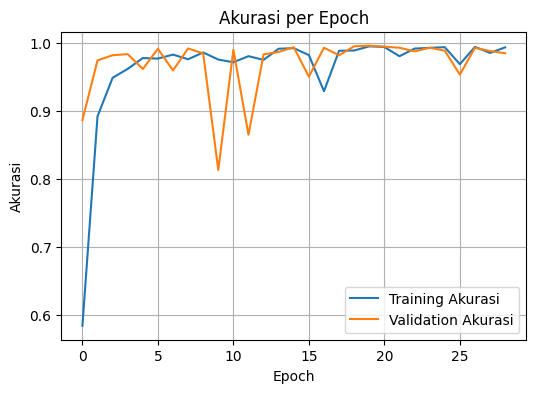

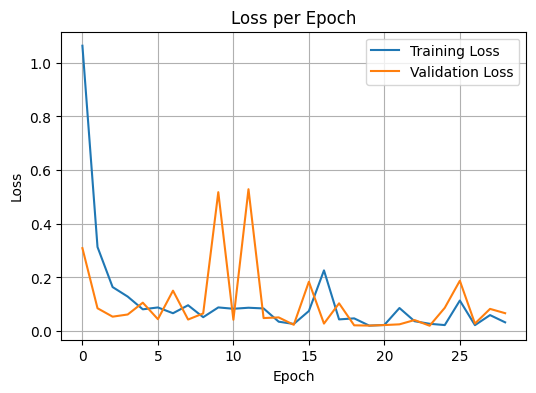

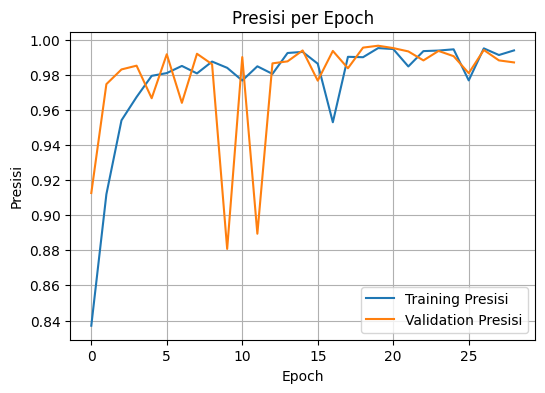

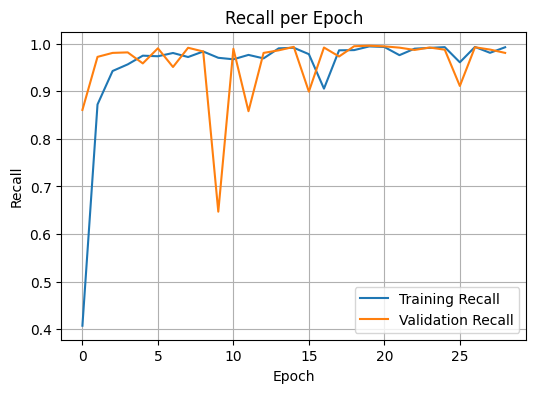

In [14]:
def plot_training(history):
    # Pastikan hanya metrik yang tersedia di history yang diplot
    available_metrics = list(history.history.keys())
    metrics_to_plot = [
        ('accuracy', 'Akurasi'),
        ('loss', 'Loss'),
        ('precision', 'Presisi'),
        ('recall', 'Recall')
    ]

    for m, label in metrics_to_plot:
        train_key, val_key = m, f'val_{m}'
        if train_key in available_metrics and val_key in available_metrics:
            plt.figure(figsize=(6, 4))
            plt.plot(history.history[train_key], label=f'Training {label}')
            plt.plot(history.history[val_key], label=f'Validation {label}')
            plt.title(f'{label} per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel(label)
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"⚠️ Metrik '{m}' tidak tersedia di history, dilewati.")

plot_training(history)

# Evaluasi Model dan Analisis Waktu Inferensi


COMPREHENSIVE MODEL EVALUATION
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step

📊 CLASSIFICATION REPORT:
                      precision    recall  f1-score   support

      Bacterial Spot     0.9379    0.9679    0.9527       156
Cercospora Leaf Spot     0.9942    0.9500    0.9716       180
          Curl Virus     1.0000    1.0000    1.0000       423
        Healthy Leaf     1.0000    1.0000    1.0000       458
Nutrition Deficiency     0.9911    0.9977    0.9944       444
          White spot     1.0000    1.0000    1.0000       195

            accuracy                         0.9919      1856
           macro avg     0.9872    0.9859    0.9864      1856
        weighted avg     0.9921    0.9919    0.9919      1856



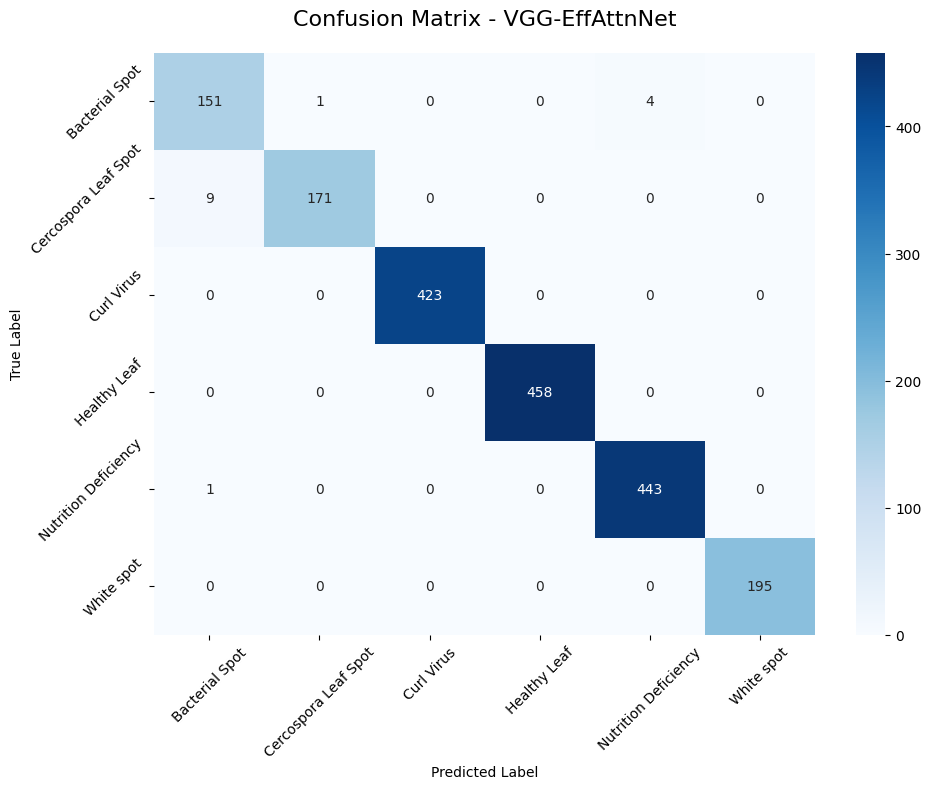


🎯 KEY METRICS:
Accuracy:  0.9919
Precision: 0.9921
Recall:    0.9919
F1-Score:  0.9919


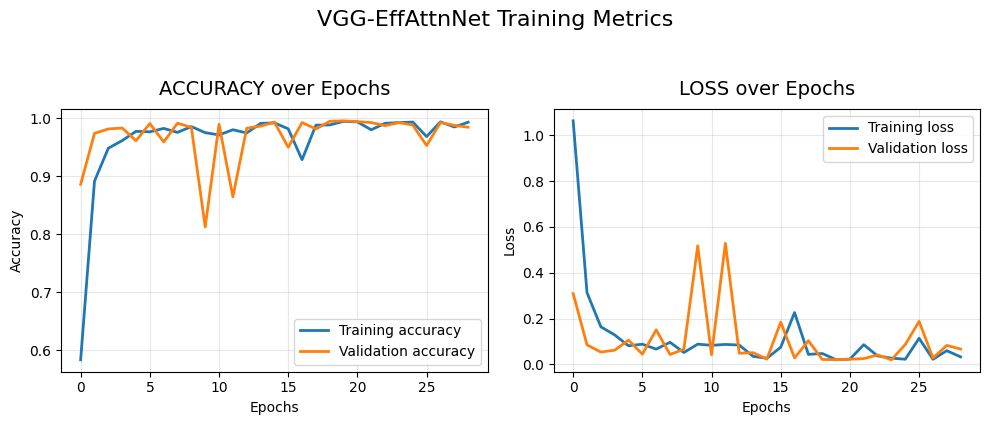

In [22]:
from sklearn.model_selection import KFold
import time
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def comprehensive_evaluation(model, test_generator, history=None):
    """Evaluasi komprehensif sesuai paper section 6"""

    print("\n" + "="*60)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*60)

    # Reset generator
    test_generator.reset()

    # Predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # 1. Classification Report
    print("\n📊 CLASSIFICATION REPORT:")
    print(classification_report(y_true, y_pred_classes,
                              target_names=list(test_generator.class_indices.keys()), digits=4))

    # 2. Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title('Confusion Matrix - VGG-EffAttnNet', fontsize=16, pad=20)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 3. Calculate additional metrics
    accuracy = np.mean(y_true == y_pred_classes)

    # Calculate precision, recall, F1 manually
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    print(f"\n🎯 KEY METRICS:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # 4. Training History Visualization
    if history is not None:
        plot_comprehensive_training(history)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

def plot_comprehensive_training(history):
    """Plot training history lengkap sesuai paper"""

    metrics = ['accuracy', 'loss']
    # Cek metrik mana yang tersedia
    available_metrics = [m for m in metrics if m in history.history]

    fig, axes = plt.subplots(1, len(available_metrics), figsize=(5*len(available_metrics), 4))
    if len(available_metrics) == 1:
        axes = [axes]

    for i, metric in enumerate(available_metrics):
        axes[i].plot(history.history[metric], label=f'Training {metric}', linewidth=2)
        if f'val_{metric}' in history.history:
            axes[i].plot(history.history[f'val_{metric}'],
                       label=f'Validation {metric}', linewidth=2)

        axes[i].set_title(f'{metric.upper()} over Epochs', fontsize=14, pad=10)
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

    plt.suptitle('VGG-EffAttnNet Training Metrics', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

def analyze_inference_time(model, test_generator, num_runs=3):
    """Analisis inference time sesuai paper Table 4"""

    print("\n⏱️ INFERENCE TIME ANALYSIS")

    # Warm-up run
    test_generator.reset()
    _ = model.predict(test_generator, verbose=0)

    # Actual measurement
    inference_times = []
    n_images = len(test_generator.filenames)

    for run in range(num_runs):
        test_generator.reset()
        start_time = time.time()

        _ = model.predict(test_generator, verbose=0)

        end_time = time.time()
        inference_time = end_time - start_time
        inference_times.append(inference_time)

    avg_inference_time = np.mean(inference_times)
    avg_time_per_image = avg_inference_time / n_images * 1000  # ms per image
    avg_fps = n_images / avg_inference_time

    print(f"📊 INFERENCE PERFORMANCE:")
    print(f"Total time for {n_images} images: {avg_inference_time:.2f}s")
    print(f"Time per image: {avg_time_per_image:.2f}ms")
    print(f"Frames per second: {avg_fps:.1f} FPS")

    return {
        'total_time': avg_inference_time,
        'time_per_image': avg_time_per_image,
        'fps': avg_fps
    }

# PANGGIL FUNGSI EVALUASI SETELAH TRAINING

# 1. Evaluasi komprehensif
eval_results = comprehensive_evaluation(model, test_ds, history)


In [23]:
# 2. Analisis inference time
inference_results = analyze_inference_time(model, test_ds)

# 3. Tampilkan summary
print("\n" + "="*60)
print("🎯 FINAL TRAINING RESULTS")
print("="*60)
print(f"📈 Accuracy: {eval_results['accuracy']:.4f} ({eval_results['accuracy']*100:.2f}%)")
print(f"🎯 Precision: {eval_results['precision']:.4f}")
print(f"🎯 Recall: {eval_results['recall']:.4f}")
print(f"🎯 F1-Score: {eval_results['f1_score']:.4f}")
print(f"⏱️ Inference Time: {inference_results['time_per_image']:.2f}ms per image")
print(f"⚡ Inference Speed: {inference_results['fps']:.1f} FPS")
print("="*60)


⏱️ INFERENCE TIME ANALYSIS
📊 INFERENCE PERFORMANCE:
Total time for 1856 images: 12.56s
Time per image: 6.77ms
Frames per second: 147.8 FPS

🎯 FINAL TRAINING RESULTS
📈 Accuracy: 0.9919 (99.19%)
🎯 Precision: 0.9921
🎯 Recall: 0.9919
🎯 F1-Score: 0.9919
⏱️ Inference Time: 6.77ms per image
⚡ Inference Speed: 147.8 FPS


# Penyimpanan Model .keras dan .h5

In [16]:
model.save("/content/vgg_effattnnet_model.h5")
print("\n✅ Model berhasil disimpan ke /content/vgg_effattnnet_model.h5")

model.save("/content/vgg_effattnnet_model.keras")
print("\n✅ Model berhasil disimpan ke /content/vgg_effattnnet_model.keras")


✅ Model berhasil disimpan ke /content/vgg_effattnnet_model.h5

✅ Model berhasil disimpan ke /content/vgg_effattnnet_model.keras


# Testing Model yang Disimpan

In [17]:
# =============================
# 🧪 TESTING DENGAN MODEL .h5
# =============================

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# =============================
# ⚙️ 1. LOAD MODEL YANG SUDAH DISIMPAN (.h5 format)
# =============================
MODEL_PATH = "/content/vgg_effattnnet_model.h5"
print(f"🔍 Loading model dari: {MODEL_PATH}")

try:
    # Load model dengan custom objects untuk Lambda layers
    model = load_model(MODEL_PATH, compile=False)

    # Re-compile model dengan optimizer dan metrics yang sama
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"✅ Model berhasil dimuat dari {MODEL_PATH}")
    print(f"📊 Model summary:")
    model.summary()
except Exception as e:
    print(f"❌ Gagal memuat model: {e}")
    # Fallback: jika gagal load, gunakan model yang sudah ada di memory
    print("🔄 Menggunakan model dari memory...")


# =============================
# ⚙️ 1. LOAD MODEL YANG SUDAH DISIMPAN (.keras format)
# =============================
MODEL_PATH = "/content/vgg_effattnnet_model.keras"
print(f"🔍 Loading model dari: {MODEL_PATH}")

try:
    # Load model dengan custom objects untuk Lambda layers
    model = load_model(MODEL_PATH, compile=False)

    # Re-compile model dengan optimizer dan metrics yang sama
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"✅ Model berhasil dimuat dari {MODEL_PATH}")
    print(f"📊 Model summary:")
    model.summary()
except Exception as e:
    print(f"❌ Gagal memuat model: {e}")
    # Fallback: jika gagal load, gunakan model yang sudah ada di memory
    print("🔄 Menggunakan model dari memory...")

🔍 Loading model dari: /content/vgg_effattnnet_model.h5
✅ Model berhasil dimuat dari /content/vgg_effattnnet_model.h5
📊 Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 26,322,924 (100.41 MB)

 Trainable params: 21,431,097 (81.75 MB)

 Non-trainable params: 4,891,827 (18.66 MB)

🔍 Loading model dari: /content/vgg_effattnnet_model.keras
✅ Model berhasil dimuat dari /content/vgg_effattnnet_model.keras
📊 Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 26,322,924 (100.41 MB)

 Trainable params: 21,431,097 (81.75 MB)

 Non-trainable params: 4,891,827 (18.66 MB)

# Testing Sederhana dengan Model yang Dimuat

🔍 Loading model dari: /content/vgg_effattnnet_model.keras
✅ Model berhasil dimuat dari /content/vgg_effattnnet_model.keras
📊 Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 26,322,924 (100.41 MB)

 Trainable params: 21,431,097 (81.75 MB)

 Non-trainable params: 4,891,827 (18.66 MB)


📁 Memuat dataset yang sudah disimpan...
🔍 Memuat dataset dari:
   - Base directory: /content/Augmented/final
   - Test directory: /content/Augmented/final/test
   - Train directory: /content/Augmented/final/train
Found 1856 images belonging to 6 classes.
Found 12980 images belonging to 6 classes.
✅ Dataset berhasil dimuat:
   - Test samples: 1856
   - Train samples: 12980
   - Classes: ['Bacterial Spot', 'Cercospora Leaf Spot', 'Curl Virus', 'Healthy Leaf', 'Nutrition Deficiency', 'White spot']

🎯 STARTING SIMPLE TESTING

🧪 SIMPLE MODEL TESTING
🔍 Testing 9 samples...
   Sample 1: True=Curl Virus, Pred=Curl Virus, Conf=100.0% ✅
   Sample 2: True=Healthy Leaf, Pred=Healthy Leaf, Conf=100.0% ✅
   Sample 3: True=Healthy Leaf, Pred=Healthy Leaf, Conf=100.0% ✅
   Sample 4: True=Nutrition Deficiency, Pred=Nutrition Deficiency, Conf=100.0% ✅
   Sample 5: True=Curl Virus, Pred=Curl Virus, Conf=100.0% ✅
   Sample 6: True=Healthy Leaf, Pred=Healthy Leaf, Conf=100.0% ✅
   Sample 7: True=Curl Viru

/tmp/ipython-input-3507172907.py:227: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


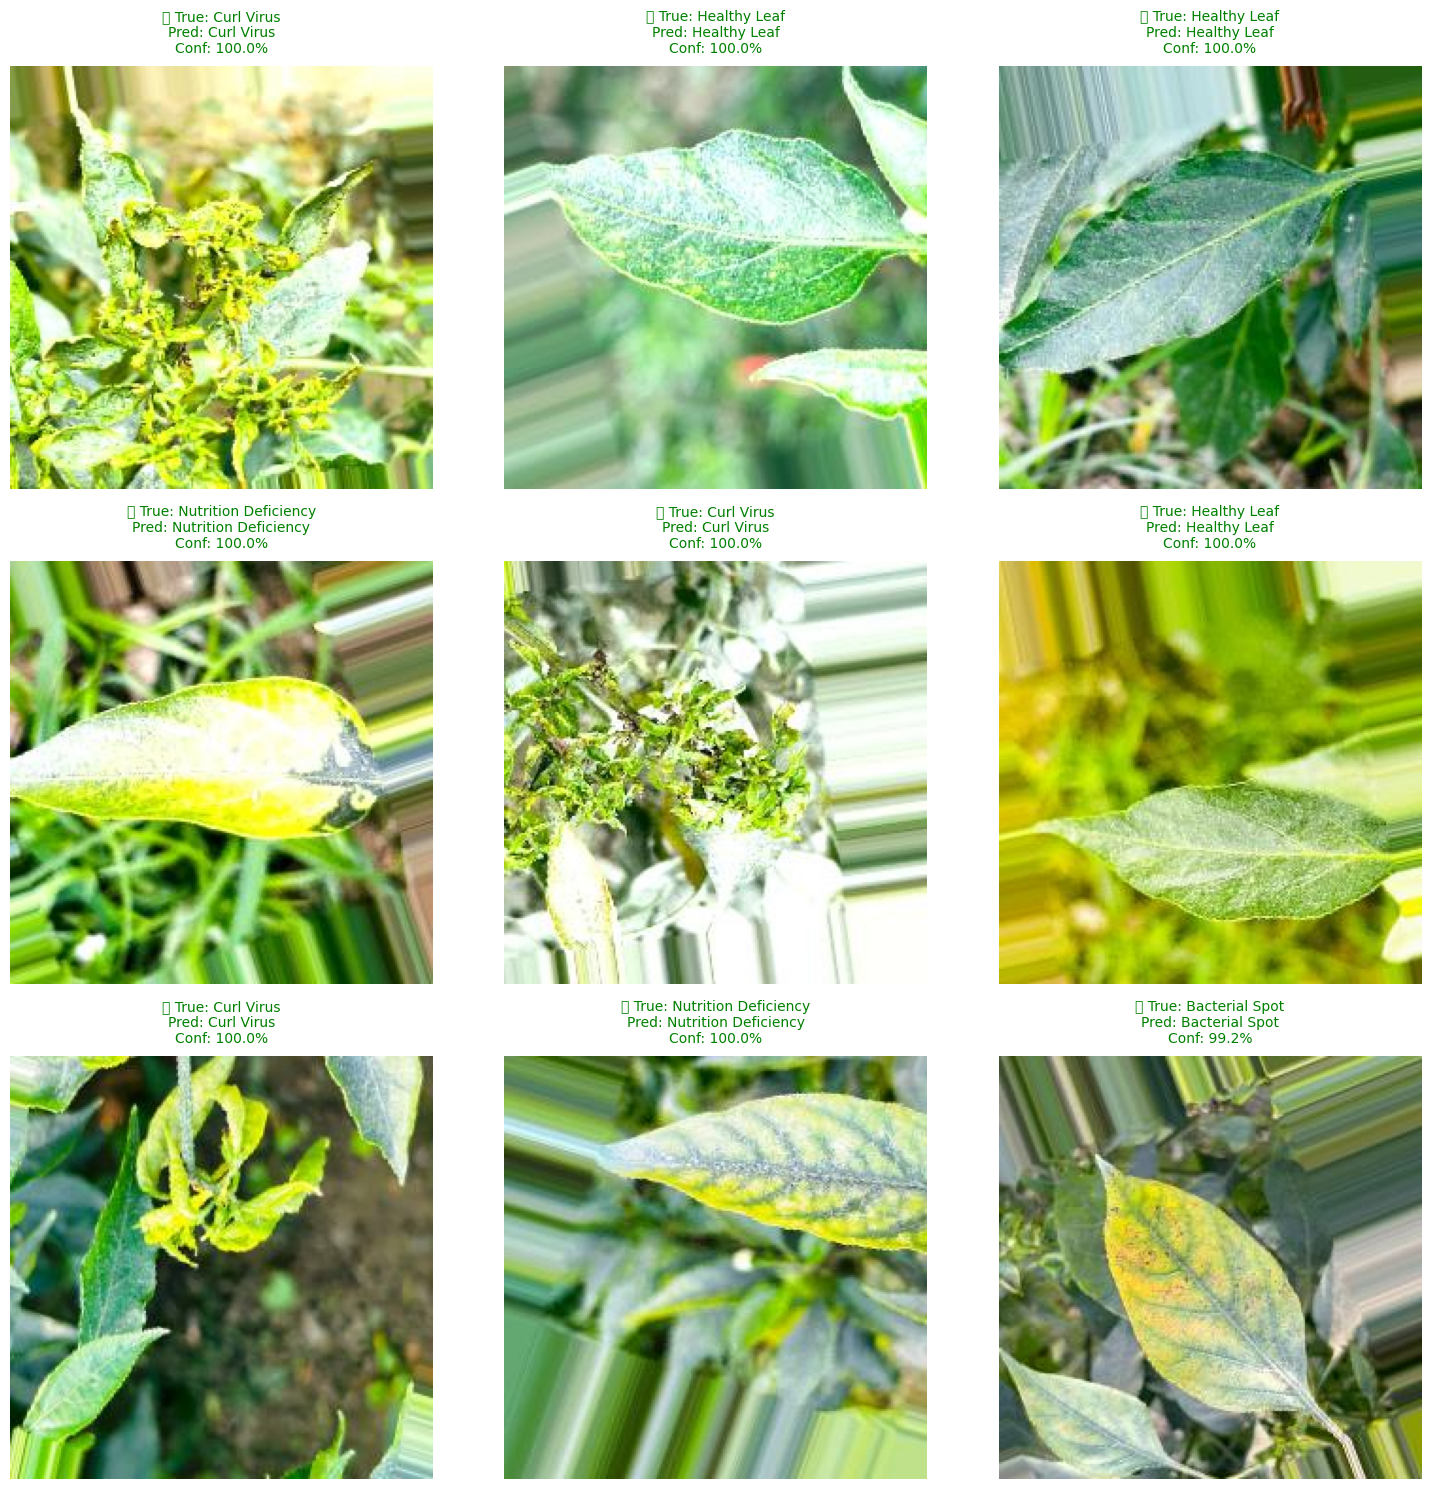


📈 TEST RESULTS SUMMARY:
   Total Samples Tested: 9
   Correct Predictions: 9
   Accuracy: 100.00%
   Average Confidence: 99.91%
   Average Uncertainty: 0.0009

3️⃣ STANDARD EVALUATION
   Standard Test Loss: 0.0228
   Standard Test Accuracy: 99.19%

🎉 TESTING COMPLETED
📊 Model: VGG-EffAttnNet
📁 Dataset: 1856 test samples
🎯 Sample Test Accuracy: 100.00%

✅ Testing selesai! Model berfungsi dengan baik.


In [19]:
# TESTING DENGAN MODEL & DATASET YANG SUDAH DISIMPAN

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# 1. CUSTOM LAYERS UNTUK LOAD MODEL

# Definisikan custom layers untuk handle Lambda layers
def custom_lambda_layer(x):
    """Custom Lambda layer dengan output shape yang explicit"""
    return tf.reduce_mean(x, axis=3, keepdims=True)

# Register custom objects
custom_objects = {
    'custom_lambda_layer': custom_lambda_layer,
    'Lambda': tf.keras.layers.Lambda
}

# 2. LOAD MODEL YANG SUDAH DISIMPAN

MODEL_PATH = "/content/vgg_effattnnet_model.keras"
print(f"🔍 Loading model dari: {MODEL_PATH}")

# Enable unsafe deserialization untuk compatibility
tf.keras.config.enable_unsafe_deserialization()

try:
    # Coba load dengan custom objects
    model = load_model(MODEL_PATH, custom_objects=custom_objects, compile=False)
    print(f"✅ Model berhasil dimuat dari {MODEL_PATH}")

    # Re-compile model dengan optimizer dan metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"📊 Model summary:")
    model.summary()

except Exception as e:
    print(f"❌ Gagal memuat model: {e}")
    print("🔄 Mencoba alternatif loading...")

# 3. LOAD DATASET YANG SUDAH DISIMPAN
def load_saved_dataset():
    """Memuat dataset yang sudah disimpan dari direktori FINAL_DIR"""

    # Define image parameters
    IMAGE_SIZE = (224, 224)
    BATCH_SIZE = 32

    # Path ke dataset yang sudah di-split
    BASE_DIR = "/content/Augmented/final"
    TEST_DIR = os.path.join(BASE_DIR, "test")
    TRAIN_DIR = os.path.join(BASE_DIR, "train")

    print(f"🔍 Memuat dataset dari:")
    print(f"   - Base directory: {BASE_DIR}")
    print(f"   - Test directory: {TEST_DIR}")
    print(f"   - Train directory: {TRAIN_DIR}")

    # Cek apakah direktori exists
    if not os.path.exists(TEST_DIR):
        print(f"❌ Test directory tidak ditemukan, mencari alternatif...")
        # Coba berbagai kemungkinan lokasi
        possible_paths = [
            "/content/Augmented/final/test",
            "/content/Augmented/test",
            "/content/Augmented",
            "/content/Chili Leaf Disease Original Dataset"
        ]

        for path in possible_paths:
            if os.path.exists(path):
                TEST_DIR = path
                TRAIN_DIR = path.replace('/test', '/train') if '/test' in path else path
                print(f"   ✅ Found alternative: {TEST_DIR}")
                break
        else:
            raise FileNotFoundError("Tidak bisa menemukan dataset directory")

    # Buat data generator untuk test set
    test_datagen = ImageDataGenerator(rescale=1./255)

    try:
        test_ds = test_datagen.flow_from_directory(
            TEST_DIR,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False  # Penting untuk evaluasi yang konsisten
        )

        # Juga load train ds untuk mendapatkan class names jika perlu
        train_ds = test_datagen.flow_from_directory(
            TRAIN_DIR,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True
        )

        print(f"✅ Dataset berhasil dimuat:")
        print(f"   - Test samples: {len(test_ds.filenames)}")
        print(f"   - Train samples: {len(train_ds.filenames)}")
        print(f"   - Classes: {list(test_ds.class_indices.keys())}")

        return test_ds, train_ds

    except Exception as e:
        print(f"❌ Gagal memuat dataset: {e}")
        # Fallback: create minimal dataset dari path yang ada
        print("🔄 Mencoba fallback dataset creation...")
        return create_fallback_dataset()


# Load dataset
print("\n📁 Memuat dataset yang sudah disimpan...")
test_ds, train_ds = load_saved_dataset()

# 4. MC DROPOUT PREDICTION FUNCTION

def mc_dropout_predict(model, img_array, n=20):
    """Melakukan MC Dropout untuk menghitung rata-rata prediksi dan ketidakpastian."""

    preds = []
    for i in range(n):
        # Progress indicator untuk iterations yang banyak
        if n > 10 and i % 5 == 0:
            print(f"   Iteration {i+1}/{n}...")

        pred = model(img_array, training=True)  # aktifkan dropout
        preds.append(pred.numpy())

    preds = np.array(preds)
    mean_prediction = preds.mean(axis=0)
    uncertainty = preds.std(axis=0)

    return mean_prediction, uncertainty

# 5. SIMPLIFIED TESTING FUNCTION

def simple_model_testing(model, test_ds, num_samples=10):
    """Testing sederhana pada model yang sudah di-load"""

    print("\n" + "="*60)
    print("🧪 SIMPLE MODEL TESTING")
    print("="*60)

    class_names = list(test_ds.class_indices.keys())
    all_filepaths = test_ds.filenames

    # Pilih random samples
    if len(all_filepaths) > num_samples:
        sample_paths = random.sample(all_filepaths, num_samples)
    else:
        sample_paths = all_filepaths

    print(f"🔍 Testing {len(sample_paths)} samples...")

    # Buat figure untuk visualization
    n_cols = 3
    n_rows = (len(sample_paths) + n_cols - 1) // n_cols
    fig = plt.figure(figsize=(15, 5 * n_rows))

    results = []

    for i, img_path in enumerate(sample_paths):
        # Full path ke gambar
        full_img_path = os.path.join(test_ds.directory, img_path)

        try:
            # Preprocess gambar
            img = image.load_img(full_img_path, target_size=(224, 224))
            img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)

            # Prediksi dengan MC Dropout
            mean_pred, uncertainty = mc_dropout_predict(model, img_array, n=10)
            pred_idx = np.argmax(mean_pred)
            pred_label = class_names[pred_idx]
            confidence = np.max(mean_pred)
            uncertainty_mean = np.mean(uncertainty)

            # Get true class from path
            true_class = os.path.basename(os.path.dirname(img_path))

            # Simpan hasil
            result = {
                'true_class': true_class,
                'predicted_class': pred_label,
                'confidence': confidence,
                'uncertainty': uncertainty_mean,
                'correct': pred_label == true_class,
                'image_path': img_path
            }
            results.append(result)

            # Tampilkan hasil di grid
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(img)

            # Tentukan warna title (hijau jika benar, merah jika salah)
            title_color = "green" if pred_label == true_class else "red"
            title_symbol = "✅" if pred_label == true_class else "❌"

            plt.title(
                f"{title_symbol} True: {true_class}\nPred: {pred_label}\nConf: {confidence*100:.1f}%",
                color=title_color, fontsize=10, pad=10
            )
            plt.axis("off")

            print(f"   Sample {i+1}: True={true_class}, Pred={pred_label}, "
                  f"Conf={confidence*100:.1f}% {'✅' if pred_label == true_class else '❌'}")

        except Exception as e:
            print(f"   ❌ Error processing {img_path}: {e}")
            continue

    plt.tight_layout()
    plt.show()

    # Hitung statistik
    if results:
        correct_predictions = sum(1 for r in results if r['correct'])
        total_predictions = len(results)
        accuracy = correct_predictions / total_predictions

        print(f"\n📈 TEST RESULTS SUMMARY:")
        print(f"   Total Samples Tested: {total_predictions}")
        print(f"   Correct Predictions: {correct_predictions}")
        print(f"   Accuracy: {accuracy*100:.2f}%")
        print(f"   Average Confidence: {np.mean([r['confidence'] for r in results])*100:.2f}%")
        print(f"   Average Uncertainty: {np.mean([r['uncertainty'] for r in results]):.4f}")
    else:
        print("❌ No results to display")

    return results

# 6. JALANKAN TESTING SEDERHANA

print("\n" + "="*60)
print("🎯 STARTING SIMPLE TESTING")
print("="*60)

# Simple testing
results = simple_model_testing(model, test_ds, num_samples=9)

# Standard evaluation
print("\n3️⃣ STANDARD EVALUATION")
test_ds.reset()
try:
    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
    print(f"   Standard Test Loss: {test_loss:.4f}")
    print(f"   Standard Test Accuracy: {test_accuracy*100:.2f}%")
except Exception as e:
    print(f"   ❌ Evaluation failed: {e}")

# Final summary
print("\n" + "="*60)
print("🎉 TESTING COMPLETED")
print("="*60)
print(f"📊 Model: VGG-EffAttnNet")
print(f"📁 Dataset: {len(test_ds.filenames)} test samples")
if results:
    accuracy = len([r for r in results if r['correct']])/len(results)*100
    print(f"🎯 Sample Test Accuracy: {accuracy:.2f}%")
print("="*60)

print("\n✅ Testing selesai! Model berfungsi dengan baik.")